In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Interpolation with PyMC3

## A 1D example

To start, we'll do a simple 1D example where we have a model evaluated at control points and we interpolate between them to estimate the model value.

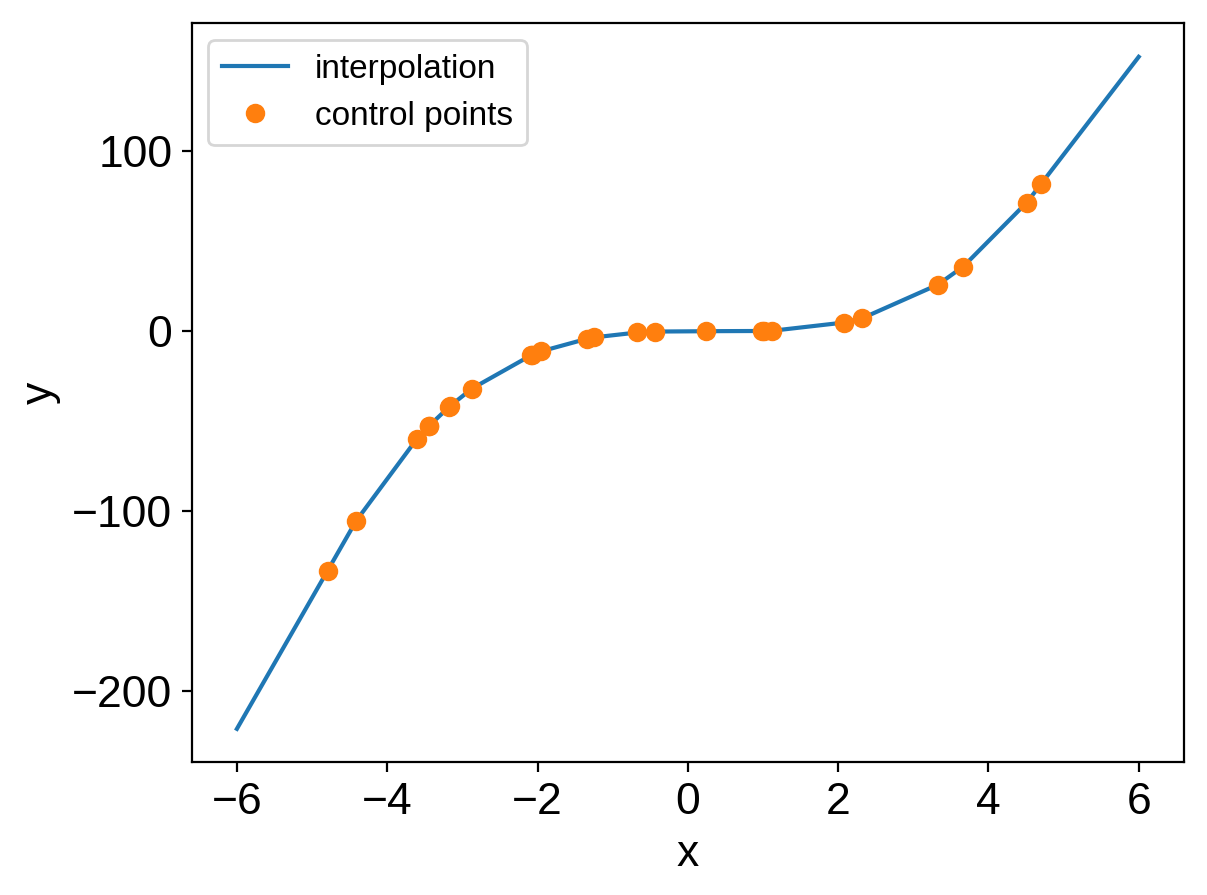

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 25))
points = [x]
values = x**3-x**2

interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])

t = np.linspace(-6, 6, 5000)
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.plot(x, values, "o", label="control points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

Here's how we build the PyMC3 model:

In [4]:
import pymc3 as pm

truth = 45.0
data_sd = 8.0
data_mu = truth + data_sd * np.random.randn()

with pm.Model() as model:
    
    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))
    
    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [x]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [00:00<00:03, 3215.65draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [00:00<00:03, 3548.32draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [00:00<00:02, 4050.55draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [00:00<00:02, 4414.77draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [00:00<00:01, 4812.95draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [00:00<00:01, 5037.25draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [00:00<00:01, 5266.46draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [00:00<00:01, 5487.43draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [00:00<00:01, 5424.80draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [00:01<00:01, 5637.12draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [00:01<00:01, 5805.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [00:01<00:00, 5658.74draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [00:01<00:00, 5508.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [00:01<00:00, 5329.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [00:01<00:00, 5269.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [00:01<00:00, 5431.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [00:01<00:00, 5624.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [00:01<00:00, 5455.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [00:01<00:00, 5529.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [00:02<00:00, 4803.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [00:02<00:00, 3649.13draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4878.75draws/s]

And here are the results:

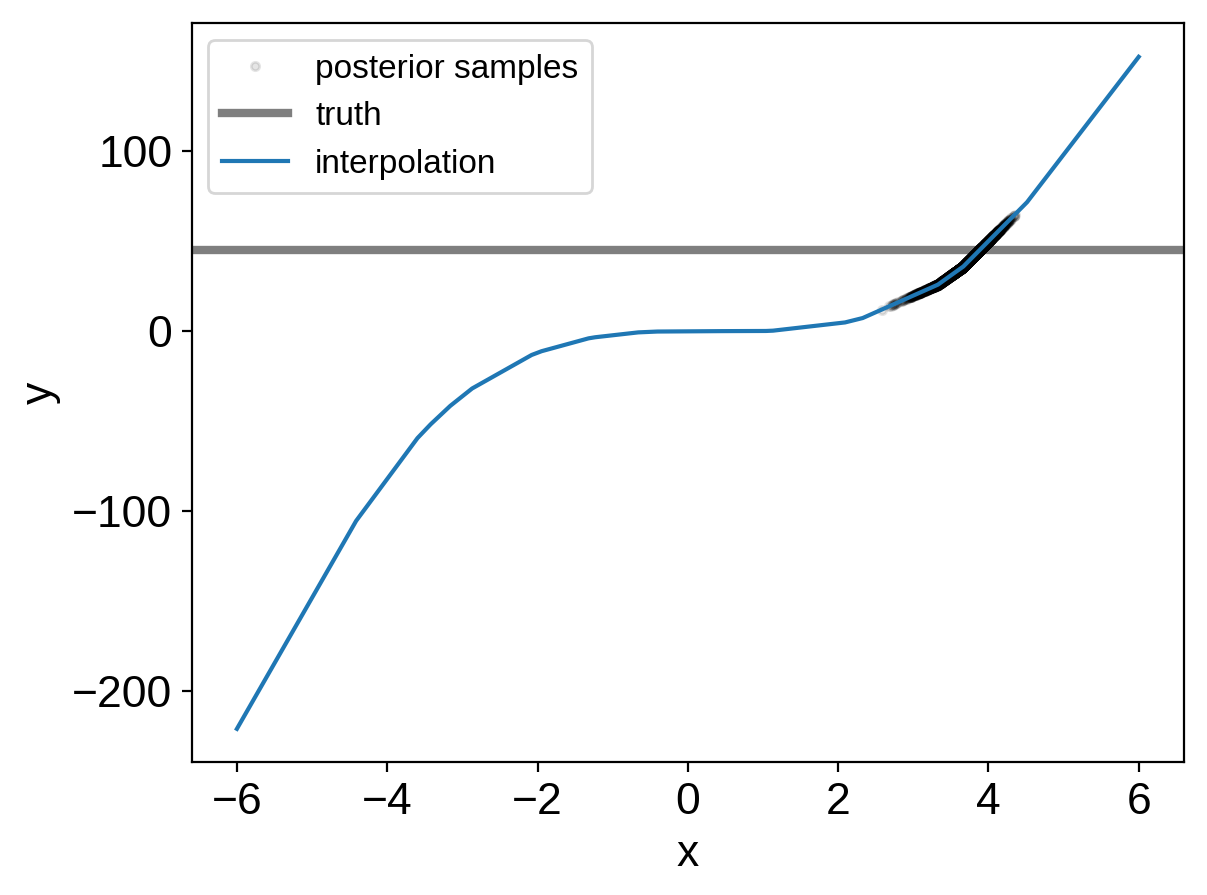

In [5]:
t = np.linspace(-6, 6, 5000)
plt.plot(trace["x"][:, 0, 0], trace["y"], ".k", alpha=0.1, label="posterior samples")
plt.axhline(truth, color="k", lw=3, alpha=0.5, label="truth")
plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=12);

## A 2D example

In this case, we'll interpolate a 2D function. This one is a hard one because the posterior is a ring, but it demonstrates the principle.

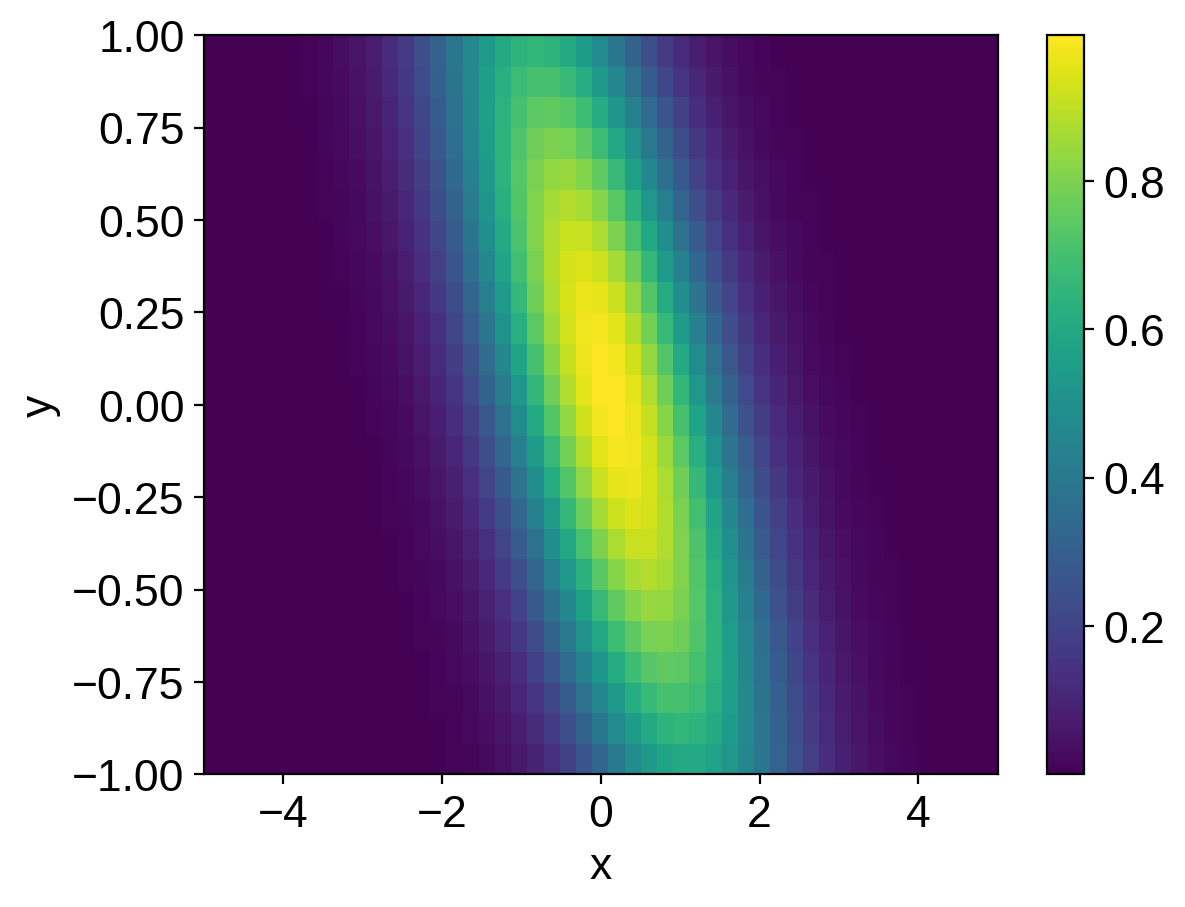

In [6]:
points = [
    np.linspace(-5, 5, 50),
    np.linspace(-1, 1, 25),
]
values = np.exp(-0.5*(points[0]**2)[:, None] - 0.5*(points[1]**2 / 0.5)[None, :] - points[0][:, None]*points[1][None, :])

interpolator = xo.interp.RegularGridInterpolator(points, values[:, :, None], nout=1)

plt.pcolor(points[0], points[1], values.T)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y");

Set things up and sample.

In [7]:
import theano.tensor as tt

data_mu = 0.6
data_sd = 0.1

with pm.Model() as model:
    
    xval = pm.Uniform("x", lower=-5, upper=5, shape=(1,))
    yval = pm.Uniform("y", lower=-1, upper=1, shape=(1,))
    xtest = tt.stack([xval, yval], axis=-1)
    
    mod = interpolator.evaluate(xtest)
    
    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)
    
    # Sampling!
    trace = pm.sample(draws=4000, tune=4000, step_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [y, x]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 85/32000 [00:00<00:38, 835.78draws/s]

Sampling 4 chains:   1%|          | 214/32000 [00:00<00:34, 934.01draws/s]

Sampling 4 chains:   1%|          | 350/32000 [00:00<00:30, 1029.14draws/s]

Sampling 4 chains:   1%|▏         | 466/32000 [00:00<00:29, 1064.58draws/s]

Sampling 4 chains:   2%|▏         | 579/32000 [00:00<00:29, 1082.65draws/s]

Sampling 4 chains:   2%|▏         | 731/32000 [00:00<00:26, 1184.65draws/s]

Sampling 4 chains:   3%|▎         | 933/32000 [00:00<00:22, 1352.12draws/s]

Sampling 4 chains:   4%|▎         | 1136/32000 [00:00<00:20, 1501.76draws/s]

Sampling 4 chains:   4%|▍         | 1322/32000 [00:00<00:19, 1591.40draws/s]

Sampling 4 chains:   5%|▍         | 1522/32000 [00:01<00:18, 1688.86draws/s]

Sampling 4 chains:   5%|▌         | 1708/32000 [00:01<00:17, 1736.69draws/s]

Sampling 4 chains:   6%|▌         | 1905/32000 [00:01<00:16, 1794.61draws/s]

Sampling 4 chains:   7%|▋         | 2089/32000 [00:01<00:17, 1755.73draws/s]

Sampling 4 chains:   7%|▋         | 2268/32000 [00:01<00:16, 1763.83draws/s]

Sampling 4 chains:   8%|▊         | 2454/32000 [00:01<00:16, 1788.59draws/s]

Sampling 4 chains:   8%|▊         | 2650/32000 [00:01<00:15, 1835.61draws/s]

Sampling 4 chains:   9%|▉         | 2852/32000 [00:01<00:15, 1886.77draws/s]

Sampling 4 chains:  10%|▉         | 3056/32000 [00:01<00:15, 1928.74draws/s]

Sampling 4 chains:  10%|█         | 3251/32000 [00:01<00:15, 1819.57draws/s]

Sampling 4 chains:  11%|█         | 3436/32000 [00:02<00:16, 1784.21draws/s]

Sampling 4 chains:  11%|█▏        | 3617/32000 [00:02<00:16, 1764.97draws/s]

Sampling 4 chains:  12%|█▏        | 3795/32000 [00:02<00:16, 1751.06draws/s]

Sampling 4 chains:  12%|█▏        | 3973/32000 [00:02<00:16, 1744.47draws/s]

Sampling 4 chains:  13%|█▎        | 4149/32000 [00:02<00:16, 1671.84draws/s]

Sampling 4 chains:  14%|█▎        | 4325/32000 [00:02<00:16, 1692.95draws/s]

Sampling 4 chains:  14%|█▍        | 4496/32000 [00:02<00:16, 1673.65draws/s]

Sampling 4 chains:  15%|█▍        | 4677/32000 [00:02<00:15, 1709.87draws/s]

Sampling 4 chains:  15%|█▌        | 4852/32000 [00:02<00:15, 1721.18draws/s]

Sampling 4 chains:  16%|█▌        | 5032/32000 [00:02<00:15, 1742.80draws/s]

Sampling 4 chains:  16%|█▋        | 5224/32000 [00:03<00:14, 1792.28draws/s]

Sampling 4 chains:  17%|█▋        | 5407/32000 [00:03<00:14, 1799.53draws/s]

Sampling 4 chains:  17%|█▋        | 5594/32000 [00:03<00:14, 1816.92draws/s]

Sampling 4 chains:  18%|█▊        | 5777/32000 [00:03<00:14, 1810.79draws/s]

Sampling 4 chains:  19%|█▊        | 5960/32000 [00:03<00:14, 1814.04draws/s]

Sampling 4 chains:  19%|█▉        | 6142/32000 [00:03<00:14, 1789.01draws/s]

Sampling 4 chains:  20%|█▉        | 6326/32000 [00:03<00:14, 1803.08draws/s]

Sampling 4 chains:  20%|██        | 6507/32000 [00:03<00:14, 1757.01draws/s]

Sampling 4 chains:  21%|██        | 6684/32000 [00:03<00:14, 1738.43draws/s]

Sampling 4 chains:  21%|██▏       | 6859/32000 [00:04<00:14, 1693.65draws/s]

Sampling 4 chains:  22%|██▏       | 7048/32000 [00:04<00:14, 1747.33draws/s]

Sampling 4 chains:  23%|██▎       | 7224/32000 [00:04<00:14, 1717.54draws/s]

Sampling 4 chains:  23%|██▎       | 7399/32000 [00:04<00:14, 1721.67draws/s]

Sampling 4 chains:  24%|██▎       | 7577/32000 [00:04<00:14, 1737.19draws/s]

Sampling 4 chains:  24%|██▍       | 7752/32000 [00:04<00:14, 1698.32draws/s]

Sampling 4 chains:  25%|██▍       | 7923/32000 [00:04<00:14, 1628.56draws/s]

Sampling 4 chains:  25%|██▌       | 8091/32000 [00:04<00:14, 1642.42draws/s]

Sampling 4 chains:  26%|██▌       | 8258/32000 [00:04<00:14, 1650.48draws/s]

Sampling 4 chains:  26%|██▋       | 8424/32000 [00:04<00:14, 1598.53draws/s]

Sampling 4 chains:  27%|██▋       | 8642/32000 [00:05<00:13, 1737.52draws/s]

Sampling 4 chains:  28%|██▊       | 8822/32000 [00:05<00:13, 1755.05draws/s]

Sampling 4 chains:  28%|██▊       | 9025/32000 [00:05<00:12, 1826.92draws/s]

Sampling 4 chains:  29%|██▉       | 9214/32000 [00:05<00:12, 1845.04draws/s]

Sampling 4 chains:  29%|██▉       | 9401/32000 [00:05<00:12, 1758.80draws/s]

Sampling 4 chains:  30%|██▉       | 9580/32000 [00:05<00:12, 1747.45draws/s]

Sampling 4 chains:  31%|███       | 9775/32000 [00:05<00:12, 1802.93draws/s]

Sampling 4 chains:  31%|███       | 9966/32000 [00:05<00:12, 1832.82draws/s]

Sampling 4 chains:  32%|███▏      | 10151/32000 [00:05<00:11, 1836.17draws/s]

Sampling 4 chains:  32%|███▏      | 10336/32000 [00:05<00:11, 1822.16draws/s]

Sampling 4 chains:  33%|███▎      | 10519/32000 [00:06<00:11, 1807.55draws/s]

Sampling 4 chains:  33%|███▎      | 10701/32000 [00:06<00:12, 1771.10draws/s]

Sampling 4 chains:  34%|███▍      | 10879/32000 [00:06<00:11, 1771.22draws/s]

Sampling 4 chains:  35%|███▍      | 11057/32000 [00:06<00:12, 1683.54draws/s]

Sampling 4 chains:  35%|███▌      | 11227/32000 [00:06<00:12, 1629.83draws/s]

Sampling 4 chains:  36%|███▌      | 11393/32000 [00:06<00:12, 1632.81draws/s]

Sampling 4 chains:  36%|███▌      | 11578/32000 [00:06<00:12, 1681.34draws/s]

Sampling 4 chains:  37%|███▋      | 11760/32000 [00:06<00:11, 1720.09draws/s]

Sampling 4 chains:  37%|███▋      | 11933/32000 [00:06<00:11, 1698.35draws/s]

Sampling 4 chains:  38%|███▊      | 12130/32000 [00:07<00:11, 1770.93draws/s]

Sampling 4 chains:  38%|███▊      | 12309/32000 [00:07<00:11, 1694.30draws/s]

Sampling 4 chains:  39%|███▉      | 12481/32000 [00:07<00:12, 1621.75draws/s]

Sampling 4 chains:  40%|███▉      | 12645/32000 [00:07<00:12, 1609.35draws/s]

Sampling 4 chains:  40%|████      | 12812/32000 [00:07<00:11, 1622.46draws/s]

Sampling 4 chains:  41%|████      | 12989/32000 [00:07<00:11, 1663.82draws/s]

Sampling 4 chains:  41%|████▏     | 13204/32000 [00:07<00:10, 1783.71draws/s]

Sampling 4 chains:  42%|████▏     | 13403/32000 [00:07<00:10, 1836.77draws/s]

Sampling 4 chains:  42%|████▏     | 13590/32000 [00:07<00:10, 1776.17draws/s]

Sampling 4 chains:  43%|████▎     | 13782/32000 [00:07<00:10, 1813.00draws/s]

Sampling 4 chains:  44%|████▎     | 13966/32000 [00:08<00:10, 1739.33draws/s]

Sampling 4 chains:  44%|████▍     | 14142/32000 [00:08<00:10, 1721.30draws/s]

Sampling 4 chains:  45%|████▍     | 14316/32000 [00:08<00:10, 1715.96draws/s]

Sampling 4 chains:  45%|████▌     | 14492/32000 [00:08<00:10, 1723.01draws/s]

Sampling 4 chains:  46%|████▌     | 14672/32000 [00:08<00:09, 1743.10draws/s]

Sampling 4 chains:  46%|████▋     | 14850/32000 [00:08<00:09, 1747.51draws/s]

Sampling 4 chains:  47%|████▋     | 15044/32000 [00:08<00:09, 1796.07draws/s]

Sampling 4 chains:  48%|████▊     | 15229/32000 [00:08<00:09, 1811.28draws/s]

Sampling 4 chains:  48%|████▊     | 15426/32000 [00:08<00:08, 1854.59draws/s]

Sampling 4 chains:  49%|████▉     | 15614/32000 [00:09<00:08, 1860.69draws/s]

Sampling 4 chains:  49%|████▉     | 15801/32000 [00:09<00:08, 1825.35draws/s]

Sampling 4 chains:  50%|████▉     | 15984/32000 [00:09<00:09, 1729.36draws/s]

Sampling 4 chains:  50%|█████     | 16159/32000 [00:09<00:09, 1698.69draws/s]

Sampling 4 chains:  51%|█████     | 16330/32000 [00:09<00:09, 1674.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16521/32000 [00:09<00:08, 1734.26draws/s]

Sampling 4 chains:  52%|█████▏    | 16721/32000 [00:09<00:08, 1805.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16904/32000 [00:09<00:08, 1758.46draws/s]

Sampling 4 chains:  53%|█████▎    | 17086/32000 [00:09<00:08, 1771.82draws/s]

Sampling 4 chains:  54%|█████▍    | 17273/32000 [00:09<00:08, 1792.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17463/32000 [00:10<00:07, 1821.78draws/s]

Sampling 4 chains:  55%|█████▌    | 17649/32000 [00:10<00:07, 1832.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17845/32000 [00:10<00:07, 1867.36draws/s]

Sampling 4 chains:  56%|█████▋    | 18041/32000 [00:10<00:07, 1891.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18231/32000 [00:10<00:07, 1854.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18417/32000 [00:10<00:07, 1833.96draws/s]

Sampling 4 chains:  58%|█████▊    | 18620/32000 [00:10<00:07, 1886.27draws/s]

Sampling 4 chains:  59%|█████▉    | 18810/32000 [00:10<00:07, 1798.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18994/32000 [00:10<00:07, 1806.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19192/32000 [00:10<00:06, 1852.64draws/s]

Sampling 4 chains:  61%|██████    | 19387/32000 [00:11<00:06, 1871.18draws/s]

Sampling 4 chains:  61%|██████    | 19579/32000 [00:11<00:06, 1874.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19779/32000 [00:11<00:06, 1908.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19973/32000 [00:11<00:06, 1917.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20175/32000 [00:11<00:06, 1945.99draws/s]

Sampling 4 chains:  64%|██████▎   | 20370/32000 [00:11<00:05, 1943.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20577/32000 [00:11<00:05, 1977.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20808/32000 [00:11<00:05, 2064.55draws/s]

Sampling 4 chains:  66%|██████▌   | 21040/32000 [00:11<00:05, 2132.58draws/s]

Sampling 4 chains:  66%|██████▋   | 21268/32000 [00:12<00:04, 2170.67draws/s]

Sampling 4 chains:  67%|██████▋   | 21513/32000 [00:12<00:04, 2242.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21739/32000 [00:12<00:04, 2076.04draws/s]

Sampling 4 chains:  69%|██████▊   | 21951/32000 [00:12<00:04, 2042.95draws/s]

Sampling 4 chains:  69%|██████▉   | 22183/32000 [00:12<00:04, 2116.12draws/s]

Sampling 4 chains:  70%|███████   | 22427/32000 [00:12<00:04, 2203.36draws/s]

Sampling 4 chains:  71%|███████   | 22650/32000 [00:12<00:04, 2099.64draws/s]

Sampling 4 chains:  71%|███████▏  | 22863/32000 [00:12<00:04, 1970.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23064/32000 [00:12<00:04, 1887.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23257/32000 [00:13<00:04, 1895.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23449/32000 [00:13<00:04, 1851.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23636/32000 [00:13<00:04, 1837.74draws/s]

Sampling 4 chains:  74%|███████▍  | 23822/32000 [00:13<00:04, 1829.54draws/s]

Sampling 4 chains:  75%|███████▌  | 24051/32000 [00:13<00:04, 1943.14draws/s]

Sampling 4 chains:  76%|███████▌  | 24275/32000 [00:13<00:03, 2022.94draws/s]

Sampling 4 chains:  76%|███████▋  | 24480/32000 [00:13<00:03, 1955.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24678/32000 [00:13<00:03, 1855.52draws/s]

Sampling 4 chains:  78%|███████▊  | 24881/32000 [00:13<00:03, 1902.41draws/s]

Sampling 4 chains:  78%|███████▊  | 25074/32000 [00:13<00:03, 1898.38draws/s]

Sampling 4 chains:  79%|███████▉  | 25266/32000 [00:14<00:03, 1857.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25475/32000 [00:14<00:03, 1921.64draws/s]

Sampling 4 chains:  80%|████████  | 25669/32000 [00:14<00:03, 1891.80draws/s]

Sampling 4 chains:  81%|████████  | 25860/32000 [00:14<00:03, 1886.01draws/s]

Sampling 4 chains:  81%|████████▏ | 26050/32000 [00:14<00:03, 1881.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26259/32000 [00:14<00:02, 1939.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26454/32000 [00:14<00:02, 1941.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26650/32000 [00:14<00:02, 1945.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26867/32000 [00:14<00:02, 2005.79draws/s]

Sampling 4 chains:  85%|████████▍ | 27069/32000 [00:14<00:02, 1993.71draws/s]

Sampling 4 chains:  85%|████████▌ | 27269/32000 [00:15<00:02, 1944.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27465/32000 [00:15<00:02, 1843.15draws/s]

Sampling 4 chains:  86%|████████▋ | 27663/32000 [00:15<00:02, 1878.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27853/32000 [00:15<00:02, 1862.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28067/32000 [00:15<00:02, 1936.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28274/32000 [00:15<00:01, 1970.31draws/s]

Sampling 4 chains:  89%|████████▉ | 28473/32000 [00:15<00:01, 1963.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28671/32000 [00:15<00:01, 1933.08draws/s]

Sampling 4 chains:  90%|█████████ | 28865/32000 [00:15<00:01, 1881.36draws/s]

Sampling 4 chains:  91%|█████████ | 29054/32000 [00:16<00:01, 1871.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29264/32000 [00:16<00:01, 1933.32draws/s]

Sampling 4 chains:  92%|█████████▏| 29459/32000 [00:16<00:01, 1916.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29652/32000 [00:16<00:01, 1826.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29836/32000 [00:16<00:01, 1808.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30045/32000 [00:16<00:01, 1884.35draws/s]

Sampling 4 chains:  94%|█████████▍| 30240/32000 [00:16<00:00, 1903.32draws/s]

Sampling 4 chains:  95%|█████████▌| 30473/32000 [00:16<00:00, 2012.32draws/s]

Sampling 4 chains:  96%|█████████▌| 30677/32000 [00:16<00:00, 1905.69draws/s]

Sampling 4 chains:  96%|█████████▋| 30873/32000 [00:16<00:00, 1910.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31081/32000 [00:17<00:00, 1954.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31279/32000 [00:17<00:00, 1745.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31459/32000 [00:17<00:00, 1737.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31639/32000 [00:17<00:00, 1751.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31824/32000 [00:17<00:00, 1780.00draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [00:17<00:00, 1807.29draws/s]

The number of effective samples is smaller than 10% for some parameters.


And here are the results:

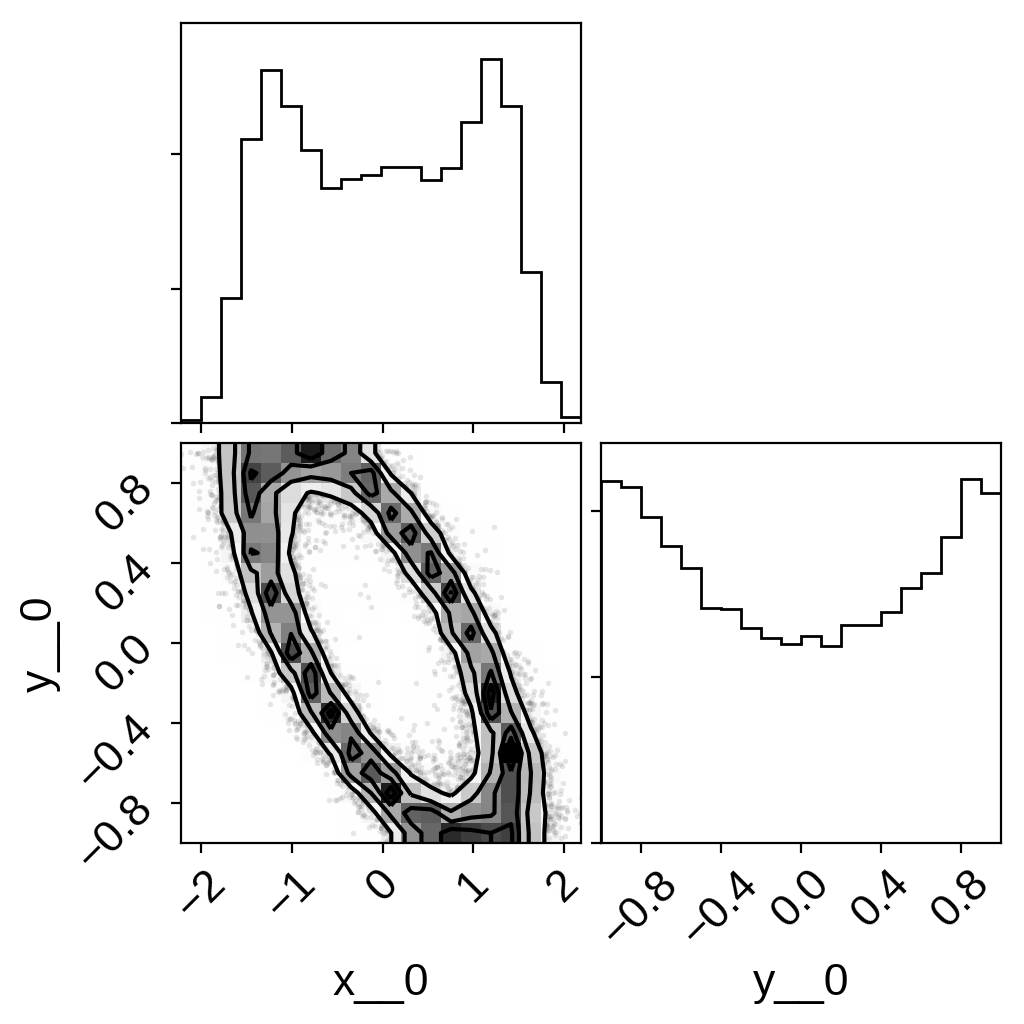

In [8]:
import corner
samples = pm.trace_to_dataframe(trace)
corner.corner(samples);